<div>
<img src="https://www.ul.ie/themes/custom/ul/logo.jpg" />
</div>

# **MSc in Artificial Intelligence and Machine Learning**
## CS6482 - Deep Reinforcement Learning
### Assignment 2: Sem2 AY 23/24 - DQN Classic Control

Module Leader: J.J. Collins

Students:  
- Pratik Verma - 23007575
- Siddharth Prince - 23052058

---
## Code checks
| Sl. No. | Test case                             | Status |
|---------|---------------------------------------|--------|
| 1.      | [Imports and setup](#Imports-and-setup)  | <span style='color: #0e0'>Passed</span> |
| 2.      | [Capture and sampling of the data](#Capture-and-sampling-of-data) | <span style='color: #0e0'>Passed</span> |
| 3.      | [Network structure and hyperparameters](#Network-structure-and-hyperparameters) | <span style='color: #0e0'>Passed</span> |
| 4.      | [Q-learning updates](#Q-learning-updates) | <span style='color: #0e0'>Passed</span> |
| 5.      | [Metrics and evalutation](#Metrics-and-evalutation) | <span style='color: #0e0'>Passed</span> |
| 6.      | [Finetuning](#Finetuning) | <span style='color: #3af'>Awaiting</span> |
|   6.1      | [Experimenting with Dueling DQN](#Experimenting-with-Dueling-DQN) | <span style='color: #3af'>Awaiting</span> |

## References
- [DQN Tutorial | Pytorch.org](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
- [A Geron's Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow - Chapter 18 Reinforcement Learning sample notebook](https://github.com/ageron/handson-ml2/blob/8958d538bdcdf29d329d9950bfc79034c29db724/18_reinforcement_learning.ipynb)

CS6482 Deep Reinforcement Learning
Template for Assignment 2 DQN CartPole Classic Control

This sample code is based on one of the recommended texts. A small number of errors were deliberately injected into the code.

If using this code as a basis for Option 1:
•	Correct the bugs.
•	Comment the code extensively.
•	Replace CartPole with a different Classic Control problem form gym.
•	Generate more informative plots i.e. plot running average.
•	Consider generating an animation.
•	Play around with hyperparameters and parameters to achieve ‘satisfactory’ performance.

A template will NOT be provided for Assignment 3. Use this template and modify the following (1) shape of obs and actions (2) network structure, (3) storing and processing of experience, etc.

## Imports and setup

In [1]:
# Common imports
import sys
import os
import math
import random
from collections import namedtuple, deque
from itertools import count

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# ML lib imports
import sklearn
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# set up matplotlib
is_ipython = 'inline' in mpl.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# OpenAI Gym import
import gym

import warnings 
warnings.filterwarnings('ignore') # To ignore the big red future warnings (for now and convenience)

In [2]:
# Version checks
assert sys.version_info >= (3,10)
assert sklearn.__version__ >= "0.20" # Scikit-Learn ≥0.20 is required

# to make this notebook's output stable across runs
SEED=42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
# Get available device for training
device = ( "cuda"     # CUDA for GPU compute
           if torch.cuda.is_available()
           else "cpu (not dice)" )   # CPU won't cut it. :P

print(f"{device} device available")

cuda device available


### Utility methods

In [4]:
# Utility methods

# Method that plots the current state of the environment as an image
# Taken from Geron's ml2 RL example notebook
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    # returns an image of the environment as a Numpy array. 
    # 'rgb-array' mode does this instead of opening a separate window that renders the image.
    img = env.render(mode="rgb_array")
    plt.imshow(img) # shows the image as a plot via Matplotlib's pyplot module in the cell output
    plt.axis("off") # does not display the plot axes and just the image.
    return img

# Method sets the current frame to be plotted for the corresponding frame in the animation
# Taken from Geron's ml2 RL example notebook
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

# Method that plots an animation of the environment that cycles through each frame that corresponds to each step taken
# Taken from Geron's ml2 RL example notebook
def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')

    # uses matplotlib's animation module. The FuncAnimation method repeatedly calls a specified method for the number of 
    # provided frames. The specified function that is called, 'update_scene' is defined above.
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

### Gym environment setup
Listing all the available OpenAI Gym environments to explore

In [5]:
allEnvs = gym.envs.registry.all() # Getting a list of all available gym environments and their specifications
envIds = [envSpec.id for envSpec in allEnvs] # Getting the id names for each environment's specification
print(sorted(envIds))

['ALE/Adventure-ram-v5', 'ALE/Adventure-v5', 'ALE/AirRaid-ram-v5', 'ALE/AirRaid-v5', 'ALE/Alien-ram-v5', 'ALE/Alien-v5', 'ALE/Amidar-ram-v5', 'ALE/Amidar-v5', 'ALE/Assault-ram-v5', 'ALE/Assault-v5', 'ALE/Asterix-ram-v5', 'ALE/Asterix-v5', 'ALE/Asteroids-ram-v5', 'ALE/Asteroids-v5', 'ALE/Atlantis-ram-v5', 'ALE/Atlantis-v5', 'ALE/Atlantis2-ram-v5', 'ALE/Atlantis2-v5', 'ALE/Backgammon-ram-v5', 'ALE/Backgammon-v5', 'ALE/BankHeist-ram-v5', 'ALE/BankHeist-v5', 'ALE/BasicMath-ram-v5', 'ALE/BasicMath-v5', 'ALE/BattleZone-ram-v5', 'ALE/BattleZone-v5', 'ALE/BeamRider-ram-v5', 'ALE/BeamRider-v5', 'ALE/Berzerk-ram-v5', 'ALE/Berzerk-v5', 'ALE/Blackjack-ram-v5', 'ALE/Blackjack-v5', 'ALE/Bowling-ram-v5', 'ALE/Bowling-v5', 'ALE/Boxing-ram-v5', 'ALE/Boxing-v5', 'ALE/Breakout-ram-v5', 'ALE/Breakout-v5', 'ALE/Carnival-ram-v5', 'ALE/Carnival-v5', 'ALE/Casino-ram-v5', 'ALE/Casino-v5', 'ALE/Centipede-ram-v5', 'ALE/Centipede-v5', 'ALE/ChopperCommand-ram-v5', 'ALE/ChopperCommand-v5', 'ALE/CrazyClimber-ram-v5'

We are choosing the _**'LunarLander-v2'**_ gym environment because (it sounds cool) it is a step up from the relatively simplistic cartpole problem while also not requiring us to deal with too many action and observation space variables. However, this environment's reward mechanism is fairly more nuanced. The full environment specification description is as follows:  
### LunarLander-v2 Specification:
#### Description:
- LunarLander is a classic rocket trajectory optimization problem.
- The goal is to land a lunar lander safely on the moon’s surface.
- The landing pad is always at coordinates (0,0).
- Fuel is infinite, allowing the agent to learn to fly and land successfully.
#### Action Space:
There are four discrete actions available:
- Do nothing
- Fire left orientation engine
- Fire main engine
- Fire right orientation engine
#### Observation Space:
The state is an 8-dimensional vector:
- Coordinates of the lander in x & y
- Linear velocities in x & y
- Angle of the lander
- Angular velocity
- Two booleans representing whether each leg is in contact with the ground or not.
#### Rewards:
- Reward for moving from the top of the screen to the landing pad and coming to rest is about 100-140 points.
- Moving away from the landing pad results in a loss of reward.
- Crashing incurs an additional -100 points.
- Successfully coming to rest earns an additional +100 points.
- Each leg with ground contact is +10 points.
- Firing the main engine costs -0.3 points per frame.
- Firing the side engine costs -0.03 points per frame.
- The environment is considered solved when the total reward reaches 200 points.
#### Starting State:
The lander starts at the top center of the viewport with a random initial force applied to its center of mass.
#### Episode Termination:
The episode finishes if:
- The lander crashes (the lander body contacts the moon).
- The lander gets outside of the viewport (x coordinate greater than 1).
- The lander is not awake (a body that doesn’t move or collide with any other body).

In [6]:
# Setting the gym environment
env = gym.make('LunarLander-v2') # setting to the LunarLander environment
obs = env.reset(seed=SEED) # initialising the environment with the reset() method 

In [7]:
obs # seeing what the observation numpy array looks like

array([ 0.00229702,  1.4181306 ,  0.2326471 ,  0.3204666 , -0.00265488,
       -0.05269805,  0.        ,  0.        ], dtype=float32)

The observation for this environment consists of 1D array with 8 float values. The array indices correspond to the following:
1. x coordinate of lander
2. y coordinate of lander
3. velocity of lander in x direction
4. velocity of lander in y direction
5. Angle or orientation of the lander
6. Angular velocity of the lander
7. 1/0 (boolean) value for the left leg contacting the lunar surface
8. 1/0 (boolean) value for the right leg contacting the lunar surface

We can see that for the starting state here, the lander already has a velocity in the positive x and y directions as well as angular velocity. This makes sense because if it were just to spawn above the landing point with no inherited velacity, it would be a straightforward controlled drop down to the surface.

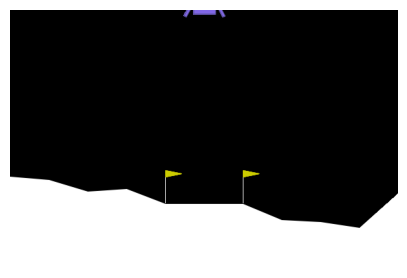

In [8]:
# Testing the rendering of LunarLander's environment
plot_environment(env)
plt.show()

## Capture and sampling of data

The action space consists of 4 actions:
- Do nothing (action index 0)
- Apply thrust using left orientation engine (action index 1)
- Apply thrust using main engine (action index 2)
- Apply thrust using right orientation engine (action index 3)

In [9]:
env.action_space

Discrete(4)

In [10]:
# Testing out an action step to get familiar with the values we're working with
action = 2  # Fire the main engine
obs, reward, done, info = env.step(action)
obs 

array([ 0.00443649,  1.4258697 ,  0.21735111,  0.34394354, -0.00602619,
       -0.06743145,  0.        ,  0.        ], dtype=float32)

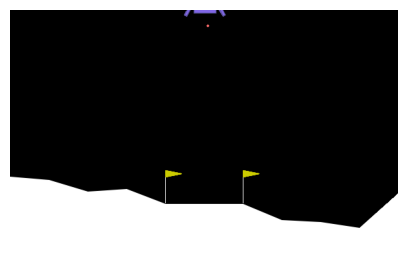

In [11]:
# Plotting the environment again to check the change in the observed state
plot_environment(env)
plt.show()

The main engine has fired from the above frame after the next step.

In [12]:
# Checking the reward obtained. This output was when I ran the first step with an action index value of 0 i.e, no action taken.
# So, the reward value starts at a non-zero positive value. I reset the env after and did this with an action index of 2 which
# is what is reflected above.
reward

-2.497033478022092

In [13]:
# Checking the reward obtained for the above step (firing the main engine for one frame)
reward

-2.497033478022092

Since firing the main engine incurs a -0.3 for a frame, we are already in the negative w.r.t to the reward value.

### Testing the env with a random policy
We just want to randomly sample an action step from the 4 available actions to see how it renders (and test if the animation works).

In [14]:
# Reset the environment to get the initial observation
obs = env.reset(seed=SEED)

frames = []
episodeReward = 0
for step in range(200): # running this for 200 frames
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = env.action_space.sample()

    obs, reward, done, info = env.step(action)
    episodeReward += reward
    if done:
        break

In [15]:
# plot the animation from all the frames (steps) captured
plot_animation(frames)

In [16]:
len(frames)

112

The random policy crashed in 98 steps.

## Network structure and hyperparameters

In [14]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [15]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [24]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 5
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state = env.reset(seed=SEED)
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [39]:
memory.memory

deque([Transition(state=tensor([[ 0.0023,  1.4181,  0.2326,  0.3205, -0.0027, -0.0527,  0.0000,  0.0000]],
              device='cuda:0'), action=tensor([[2]], device='cuda:0'), next_state=tensor([[ 0.0044,  1.4259,  0.2174,  0.3439, -0.0060, -0.0674,  0.0000,  0.0000]],
              device='cuda:0'), reward=tensor([-2.4970], device='cuda:0', dtype=torch.float64)),
       Transition(state=tensor([[ 0.0044,  1.4259,  0.2174,  0.3439, -0.0060, -0.0674,  0.0000,  0.0000]],
              device='cuda:0'), action=tensor([[1]], device='cuda:0'), next_state=tensor([[ 0.0065,  1.4330,  0.2082,  0.3177, -0.0075, -0.0304,  0.0000,  0.0000]],
              device='cuda:0'), reward=tensor([1.8075], device='cuda:0', dtype=torch.float64)),
       Transition(state=tensor([[ 0.0065,  1.4330,  0.2082,  0.3177, -0.0075, -0.0304,  0.0000,  0.0000]],
              device='cuda:0'), action=tensor([[3]], device='cuda:0'), next_state=tensor([[ 0.0086,  1.4396,  0.2173,  0.2913, -0.0109, -0.0671,  0.0000,  0

In [36]:
torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


tensor([[3]], device='cuda:0')

In [38]:
state = env.reset(seed=SEED)
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
print(state)
policy_net(state).max(1).indices.view(1, 1)

tensor([[ 0.0023,  1.4181,  0.2326,  0.3205, -0.0027, -0.0527,  0.0000,  0.0000]],
       device='cuda:0')


tensor([[1]], device='cuda:0')

## Q-learning updates

In [35]:
transitions = memory.sample(BATCH_SIZE)
# Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
# detailed explanation). This converts batch-array of Transitions
# to Transition of batch-arrays.
batch = Transition(*zip(*transitions))

# Compute a mask of non-final states and concatenate the batch elements
# (a final state would've been the one after which simulation ended)
non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                      batch.next_state)), device=device, dtype=torch.bool)
non_final_next_states = torch.cat([s for s in batch.next_state
                                            if s is not None])
state_batch = torch.cat(batch.state)
action_batch = torch.cat(batch.action)
reward_batch = torch.cat(batch.reward)
temp = policy_net(state_batch)
print(action_batch)
print(np.shape(action_batch))
print(np.shape(temp))
temp

tensor([[3],
        [2],
        [2],
        [3],
        [2]], device='cuda:0')
torch.Size([5, 1])
torch.Size([5, 4])


tensor([[ -2.7105,  -2.4926,  -1.6476,  -1.5502],
        [ -0.9454,  -0.9450,   1.5416,   0.5685],
        [ -5.4703,  -5.7332,  -0.5123,  -3.7650],
        [  0.1816,   0.6820,   1.1234,   1.1274],
        [ -9.7685, -10.5516,  -7.8528,  -7.8838]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [30]:
def optimize_model():
    global printNum
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

    if printNum < 5:
        print(f'state batch: {state_batch}')
        print(f'action batch: {action_batch}')
        print(f'reward batch: {reward_batch}')
        print(f'non_final_mask: {non_final_mask}')
        print(f'non_final_next_states: {non_final_next_states}')
        print(f'next_state_values: {next_state_values}')
        print(f'state_action_values: {state_action_values}')
        print(f'expected_state_action_values: {expected_state_action_values}')
        printNum += 1

In [31]:
if torch.cuda.is_available():
    num_episodes = 5
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    printNum = 0
    state = env.reset(seed=SEED)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        # done = terminated or truncated

        if done:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            # plot_durations()
            break

print('Complete')

state batch: tensor([[ 0.0420,  1.4861,  0.1675, -0.0354,  0.0954,  0.2882,  0.0000,  0.0000],
        [-0.2305,  0.6871, -0.1002, -0.8147, -0.8145, -0.2718,  0.0000,  0.0000],
        [ 0.0668,  0.7678, -0.3421, -0.8566,  0.8387,  0.3510,  0.0000,  0.0000],
        [-0.0153,  1.2399, -0.5236, -0.5600,  1.0184,  0.4347,  0.0000,  0.0000],
        [-0.1335,  0.8801,  0.4170, -0.3366, -0.5048,  0.1249,  0.0000,  0.0000]],
       device='cuda:0')
action batch: tensor([[1],
        [2],
        [2],
        [2],
        [2]], device='cuda:0')
reward batch: tensor([-1.4643,  1.1954, -2.1953, -4.5220,  0.3707], device='cuda:0',
       dtype=torch.float64)
non_final_mask: tensor([True, True, True, True, True], device='cuda:0')
non_final_next_states: tensor([[ 0.0437,  1.4847,  0.1590, -0.0624,  0.1115,  0.3224,  0.0000,  0.0000],
        [-0.2312,  0.6692, -0.0577, -0.8066, -0.8286, -0.2803,  0.0000,  0.0000],
        [ 0.0629,  0.7487, -0.3993, -0.8547,  0.8560,  0.3448,  0.0000,  0.0000],
 

In [43]:
# path to save checkpoints
PATH = "./models"
if not os.path.isdir(PATH):
    os.mkdir(PATH)

torch.save(policy_net.state_dict(), os.path.join(PATH, 'policy_qnetwork.pt'))

## Metrics and evalutation

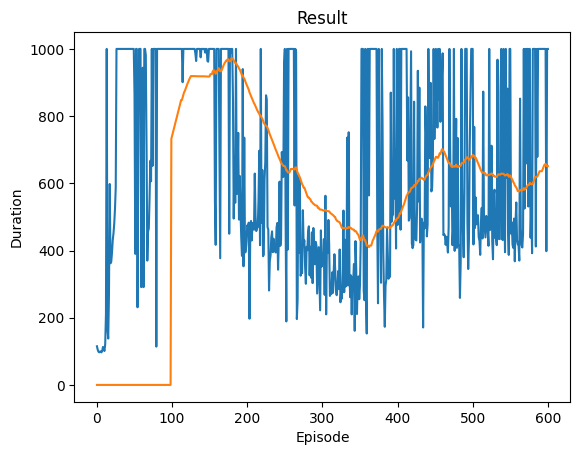

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [33]:
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [40]:
state = env.reset(seed=SEED)
state = torch.tensor(state, dtype=torch.float32, device=device)
frames = []

for step in range(200):
    action = policy_net(state).max(1).values
    state, reward, done, info = env.step(action.item())
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

## Finetuning

### Experimenting with Double DQN

### Experimenting with Dueling DQN